In [52]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [53]:
import numpy as np 
import cv2 
import math
import heapq
import sys
import matplotlib.pyplot as plt
from collections import deque
%matplotlib inline


def format_string(x, y):
    return " (" + str(x) + "," + str(y) + ")"

def draw_vertex(image, x, y):
    cv2.circle(image, (x, y), radius=1, color=(0, 0, 255), thickness=4, lineType=cv2.LINE_AA)

# get image with initial and goal state 
def get_image(image_name, initial_state, goal_state):
    font = cv2.FONT_HERSHEY_COMPLEX 
    img2 = cv2.imread(image_name, cv2.IMREAD_COLOR) 
    draw_vertex(img2, *initial_state)
    draw_vertex(img2, *goal_state)
    # Reading same image in another variable and converting to gray scale. 
    img = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE) 
    # Converting image to a binary image 
    # ( black and white only image). 
    _, threshold = cv2.threshold(img, 110, 255, cv2.THRESH_BINARY) 
    # Detecting contours in image. 
    contours, _= cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 

    # Iterating through all the contours detected in the image.
    # Iterate through all contours in the image
    for cnt in contours: 
        # Approximate the contour with a polygon
        approx = cv2.approxPolyDP(cnt, 0.01 * cv2.arcLength(cnt, True), True)  
        # Fill the contour with color
        cv2.drawContours(img2, [approx], -1, (0, 255, 0), -1)  
        # Draw the boundary of the contour
        cv2.drawContours(img2, [approx], -1, (0, 0, 255), 3)
        # Flatten the array containing the coordinates of the vertices
        n = approx.ravel()  
        i = 0
        # Iterate through the vertices
        for j in n : 
            if(i % 2 == 0): 
                x = n[i] 
                y = n[i + 1] 
                # Draw a small circle at each vertex
                cv2.circle(img2, (x, y), radius=2, color=(0, 0, 0), thickness=4, lineType=cv2.LINE_AA)
        i = i + 1
    return img2, contours

# draw path of solution
def draw_path(solution, problem, image):
    plt.figure(figsize=(20,10), dpi=80)
    img = image.copy()
    font = cv2.FONT_HERSHEY_COMPLEX 
    if solution == 'not found':
        return solution
    state = problem.initial
    for step in solution:
        cv2.circle(img, state, radius=1, color=(0, 255, 255), thickness=4, lineType=cv2.LINE_AA)
        cv2.putText(img, format_string(*state), state, font, 0.5, (0, 255, 255))  
        new_state = problem.result(state, step)
        cv2.line(img, state, new_state, (255, 111, 1), 2)
        # draw a dot at every other state
        if solution.index(step) % 2 == 0:
            cv2.circle(img, new_state, radius=1, color=(0, 0, 255), thickness=4, lineType=cv2.LINE_AA)
        state = new_state
        
        # draw a dot at every other state
        if solution.index(step) % 2 == 0:
            cv2.circle(img, new_state, radius=1, color=(0, 0, 255), thickness=4, lineType=cv2.LINE_AA)
        
        state = new_state
    
    cv2.circle(img, problem.goal, radius=1, color=(0, 255, 255), thickness=4, lineType=cv2.LINE_AA)
    cv2.putText(img, format_string(*problem.goal), problem.goal, font, 0.5, (0, 255, 255))  
        
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

# Problem

In [54]:
# States: Vertices (x, y) of the polygons
# Initial State: Initial location S = (188, 418)
# Actions: Set of vectors, each of which maps the current vertex to one of the vertices that can be reached in a straight line.
# Transition model: Given a state and action, this returns the resulting state;
# Goal Test: Current location (x, y) == GOAL_STATE = (1014, 30)
# Path Cost: Length of a straight line between vertices
# Heuristic Function: Length of a straight line between initial and goal state

In [55]:
class Problem:
    
    def __init__(self, initial, goal, img, contours):
        self.initial = initial
        self.goal = goal
        self.img = img
        self.contours = contours
        
    # check if point_2 can be reached in a straight line without intersecting any obstacles
    def is_intersect(self, img, point_1, point_2):
        if point_1 == point_2:
            return True
        blank = np.zeros(img.shape)
        img_line = cv2.line(blank.copy(), point_1, point_2, (0, 255, 0))
        return np.logical_and(img, img_line).any()
        
    # Obtain all possible actions (vectors) that can be taken from the current state.
    def actions(self, state):
        x, y = state
        vectors = []
        for cnt in self.contours:
            approx = cv2.approxPolyDP(cnt, 0.01 * cv2.arcLength(cnt, True), True) 
            i = 0
            n = approx.ravel()
            for j in n:
                if(i % 2 == 0):
                    x_1 = n[i] 
                    y_1 = n[i + 1]
                    if not self.is_intersect(self.img, (x, y), (x_1, y_1)):
                        vectors.append((x_1-x,y_1-y))
                i += 1
        x_1, y_1 = self.goal
        if not self.is_intersect(self.img, (x, y), (x_1, y_1)):
            vectors.append((x_1-x,y_1-y))
        x_1, y_1 = self.initial
        if not self.is_intersect(self.img, (x, y), (x_1, y_1)):
            vectors.append((x_1-x,y_1-y))
        return vectors
    
    # Generate the new state (x, y) based on the current state and the chosen action
    def result(self, state, action):
        x_1, y_1 = state
        v1, v2 = action
        return (x_1 + v1, y_1 + v2)
        
    # Cost of moving from one state to another using a particular action is based on the length of the vector representing the action
    def step_cost(self, action):
        v1, v2 = action
        return round(math.sqrt(v1 ** 2 + v2 ** 2))
    
    def heuristic_function(self, state):
        # get the x,y coordinates of the goal state
        x_goal, y_goal = self.goal
        # get the x,y coordinates of the current state
        x, y = state
        # calculate the distance between the current state and the goal state using the euclidean distance formula and return it as the heuristic value
        return self.step_cost((x_goal - x, y_goal - y))
    
    # check if goal state
    def goal_test(self, state):
        return self.goal == state

In [56]:
def __init__(self):
    self.heap = []
    
def append(self, priority, item):
    heapq.heappush(self.heap, (priority, item))

def pop(self):
    # get and remove the top element from the priority queue
    return heapq.heappop(self.heap)[1]

def empty(self):
    # return True if the priority queue is empty
    return len(self.heap) == 0

def __len__(self):
    # return the number of elements in the priority queue
    return len(self.heap)

def __contains__(self, key):
    # return True if the priority queue contains the given key
    return any([item == key for _, item in self.heap])

def __getitem__(self, key):
    # return the priority of the given key
    for value, item in self.heap:
        if item == key:
            return value

def __delitem__(self, key):
    # remove the given key from the priority queue
    del self.heap[[item == key for _, item in self.heap].index(True)]
    heapq.heapify(self.heap)

In [57]:
class Node:

    def __init__(self, state, action=None, parent=None, path_cost=0):
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost
        if parent:
            self.depth = parent.depth + 1
        else:
            self.depth = 0

    # create a child node given a problem, action, and the parent node
    def child_node(self, problem, action):
        new_state = problem.result(self.state, action) # get the new state after taking the action
        if self.parent:
            path_cost = self.parent.path_cost + problem.step_cost(action) # add the cost of the action to the path cost
        else:
            path_cost = problem.step_cost(action)
        return Node(new_state, action, self, path_cost)

    # get a list of actions to get to the current node
    def solution(self):
        return [node.action for node in self.path()[1:]]

    # get a list of nodes from the root node to the current node
    def path(self):
        node = self
        path_back = []
        while node:
            path_back.append(node)
            node = node.parent
        return list(reversed(path_back))

    # get a list of child nodes
    def expand(self, problem):
        lst = []
        actions = problem.actions(self.state)
        for action in actions:
            lst.append(self.child_node(problem, action))
        return lst

    def __cmp__(self, other):
        return cmp(self.state, other.state)

    def __hash__(self):
        return hash(self.state)
    
    def __eq__(self, other):
        return isinstance(other, Node) and self.state == other.state
    
    def __lt__(self, other):
        return isinstance(other, Node) and (self.path_cost < other.path_cost)


In [58]:
def answer(ans):
    for node in ans.path():
        print(f"State: {node.state}")
        print(f"Action: {node.action}")
        print(f"Cost at this state: {node.path_cost}")
    # print total path cost after loop
    print(f"Total path cost: {ans.path_cost}")

In [59]:
initial_state = (188, 418)
goal_state = (1014, 30)
image_name = 'map.png'
#build problem
result_img, contours = get_image(image_name, initial_state, goal_state)
problem = Problem(initial_state, goal_state, result_img, contours)


## Tree Search


In [60]:
# Using Tree Search gives us an infitine loop and we can detect that it's stucked: 
# State: (205, 261), Action: (17, -157)
# State: (188, 418), Action: (-17, 157)

Expanding state: (221, 350)
Expanding state: (221, 472)
Expanding state: (181, 140)
Expanding state: (205, 261)
Expanding state: (221, 350)
Expanding state: (221, 472)
Expanding state: (607, 350)
Expanding state: (181, 140)
Expanding state: (336, 292)
Expanding state: (188, 418)
Expanding state: (221, 350)
Expanding state: (221, 472)
Expanding state: (181, 140)
Expanding state: (205, 261)
Expanding state: (221, 350)
Expanding state: (221, 472)
Expanding state: (607, 350)
Expanding state: (181, 140)
Expanding state: (336, 292)
Expanding state: (188, 418)
Expanding state: (221, 350)
Expanding state: (221, 472)
Expanding state: (181, 140)
Expanding state: (205, 261)
Expanding state: (221, 350)
Expanding state: (221, 472)
Expanding state: (607, 350)
Expanding state: (181, 140)
Expanding state: (336, 292)
Expanding state: (188, 418)
Expanding state: (221, 350)
Expanding state: (221, 472)
Expanding state: (181, 140)
Expanding state: (205, 261)
Expanding state: (221, 350)
Expanding state: (22

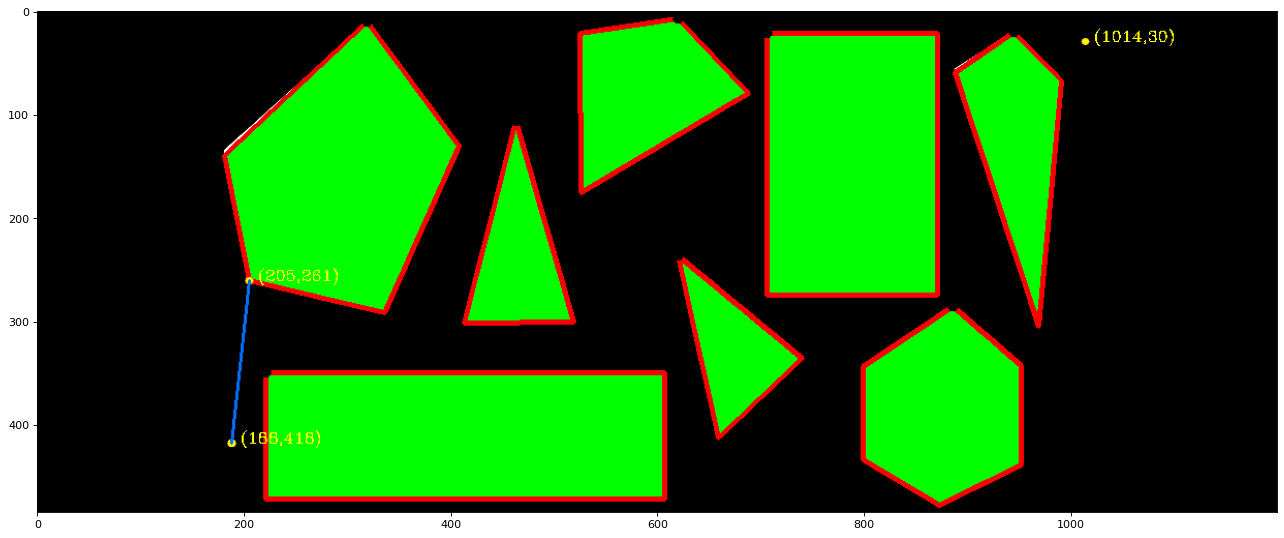

State: (188, 418)
Action: None
Cost at this state: 0
State: (205, 261)
Action: (17, -157)
Cost at this state: 158
State: (188, 418)
Action: (-17, 157)
Cost at this state: 158
State: (205, 261)
Action: (17, -157)
Cost at this state: 316
State: (188, 418)
Action: (-17, 157)
Cost at this state: 316
State: (205, 261)
Action: (17, -157)
Cost at this state: 474
State: (188, 418)
Action: (-17, 157)
Cost at this state: 474
State: (205, 261)
Action: (17, -157)
Cost at this state: 632
State: (188, 418)
Action: (-17, 157)
Cost at this state: 632
State: (205, 261)
Action: (17, -157)
Cost at this state: 790
State: (188, 418)
Action: (-17, 157)
Cost at this state: 790
Total path cost: 790
CPU times: total: 4.72 s
Wall time: 4.75 s


In [61]:
%%time
def tree_search(problem):
    # initialize the frontier using the initial state of problem
    frontier = [Node(problem.initial)] # LIFO queue
    count = 0
    while frontier:
        leaf_node = frontier.pop() # LIFO queue
        if problem.goal_test(leaf_node.state):
            return leaf_node
        for new_node in leaf_node.expand(problem):
            print(f"Expanding state: {new_node.state}")
            frontier.append(new_node)
        count += 1
        if count > 10:
            return leaf_node
    return None



result = tree_search(problem)
draw_path(result.solution(), problem, result_img)
answer(result)

In [ ]:
#Let's try other methods

## Breadth First Search

In [43]:
# In this case we can see the results

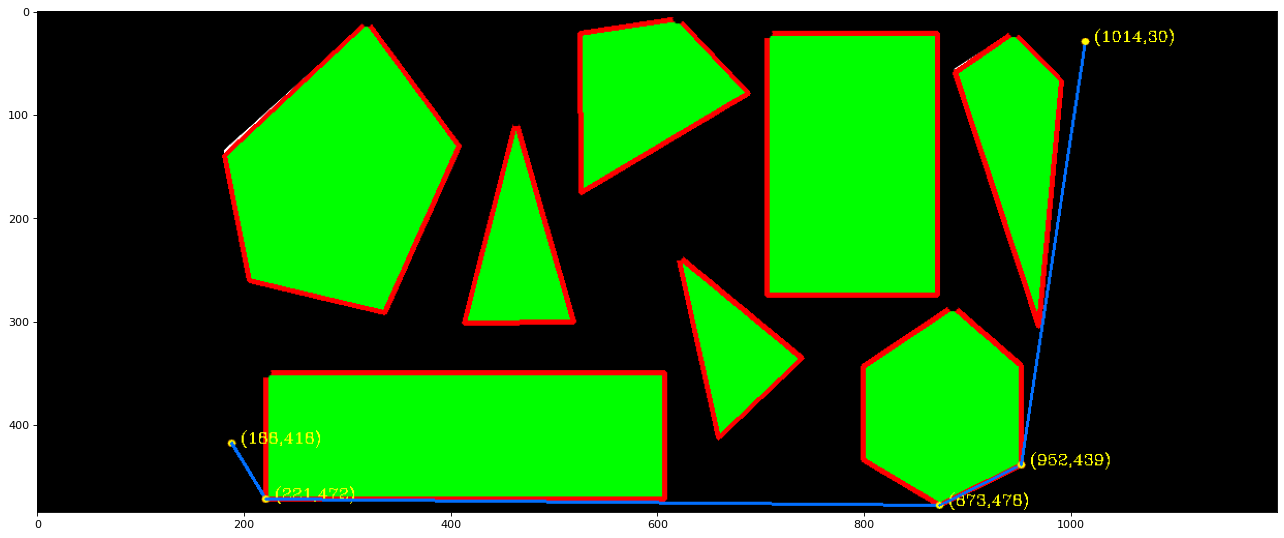

State: (188, 418)
Action: None
Cost at this state: 0
State: (221, 472)
Action: (33, 54)
Cost at this state: 63
State: (873, 478)
Action: (652, 6)
Cost at this state: 652
State: (952, 439)
Action: (79, -39)
Cost at this state: 151
State: (1014, 30)
Action: (62, -409)
Cost at this state: 1066
Total path cost: 1066
CPU times: total: 39.8 s
Wall time: 39.9 s


In [44]:
%%time
def breadth_first_search(problem):
    node = Node(problem.initial)
    if problem.goal_test(node.state):
        return node
    frontier = deque([node]) #FIFO queue
    explored = set()
    while frontier:
        node = frontier.popleft()
        explored.add(node.state)
        for action in problem.actions(node.state):
            child = node.child_node(problem, action)
            if child.state not in explored or child.state not in frontier:
                if problem.goal_test(child.state):
                    return child
                frontier.append(child)
                
result = breadth_first_search(problem)
draw_path(result.solution(), problem, result_img)
answer(result)

##  Depth-limited search

In [49]:
# Here we can also see the result 

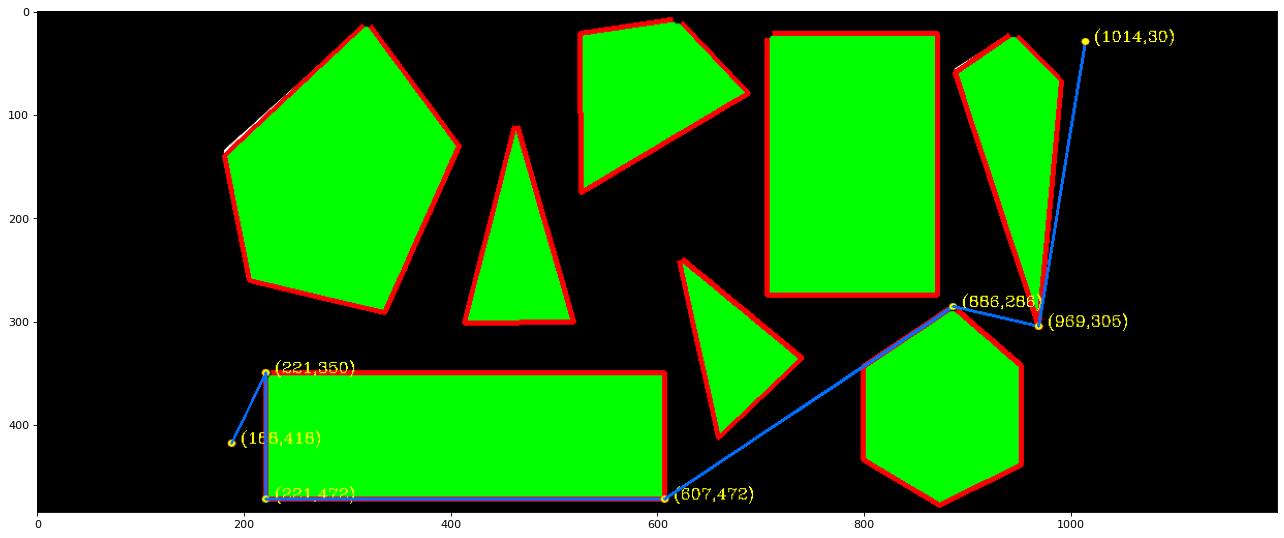

State: (188, 418)
Action: None
Cost at this state: 0
State: (221, 350)
Action: (33, -68)
Cost at this state: 76
State: (221, 472)
Action: (0, 122)
Cost at this state: 122
State: (607, 472)
Action: (386, 0)
Cost at this state: 462
State: (886, 286)
Action: (279, -186)
Cost at this state: 457
State: (969, 305)
Action: (83, 19)
Cost at this state: 547
State: (1014, 30)
Action: (45, -275)
Cost at this state: 736
Total path cost: 736
CPU times: total: 37.4 s
Wall time: 37.5 s


In [48]:
%%time
def recursive_dls(node, problem, limit):
    if problem.goal_test(node.state):
        return node
    elif limit == 0:
        return 'not found'
    else:
        cutoff_occured = False
        for action in problem.actions(node.state):
            child = node.child_node(problem, action)
            result = recursive_dls(child, problem, limit - 1)
            if result == 'not found':
                cutoff_occured = True
            elif result is not None:
                return result
        return 'not found' if cutoff_occured else None

def depth_limited_search(problem, limit):
    return recursive_dls(Node(problem.initial), problem, limit)

result = depth_limited_search(problem, 6)
draw_path(result.solution(), problem, result_img)
answer(result)

## Iterative deepening depth-first search


In [ ]:
# Let's try one more method base on previous one
# Actually it took more time that any others

Depth: 1
Depth: 2
Depth: 3
Depth: 4
Depth: 5


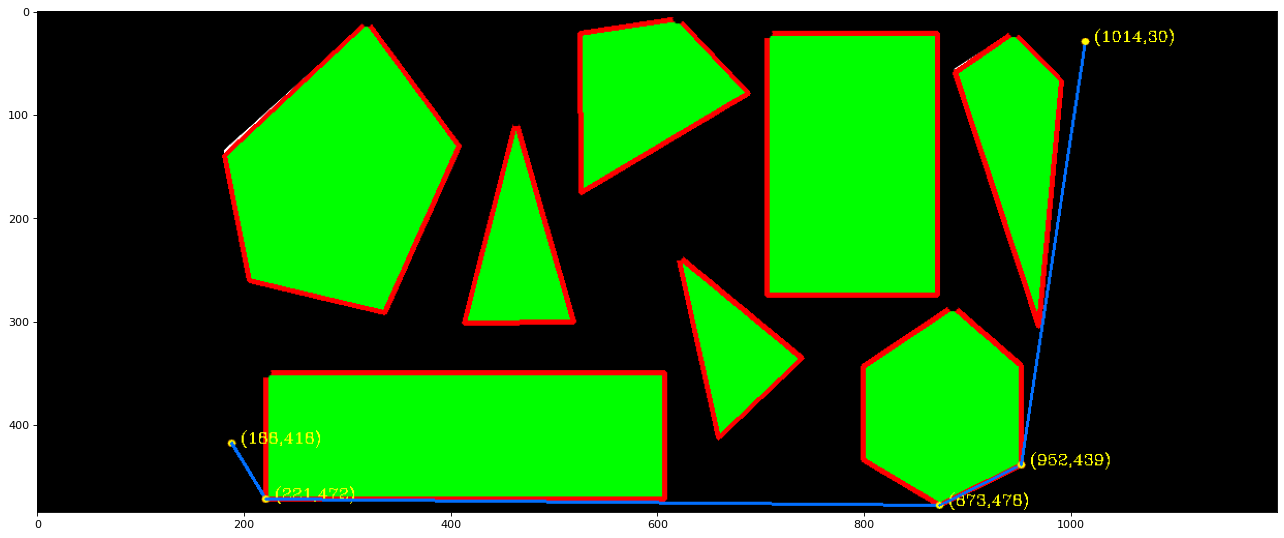

State: (188, 418)
Action: None
Cost at this state: 0
State: (221, 472)
Action: (33, 54)
Cost at this state: 63
State: (873, 478)
Action: (652, 6)
Cost at this state: 652
State: (952, 439)
Action: (79, -39)
Cost at this state: 151
State: (1014, 30)
Action: (62, -409)
Cost at this state: 1066
Total path cost: 1066
CPU times: total: 51.8 s
Wall time: 52.8 s


In [51]:
%%time
def iterative_deepening_search(problem):
    depth = 0
    for depth in range(sys.maxsize):
        result = depth_limited_search(problem, depth)
        depth += 1
        print("Depth: {}".format(depth))
        if result != 'not found':
            return result
        
result = iterative_deepening_search(problem)
draw_path(result.solution(), problem, result_img)
answer(result)